In [71]:
using Pkg
Pkg.activate("..")
using Revise
using FUSE
using Plots; gr();

  Activating project at `~/Coding/julia/FUSE`


In [72]:
gasc_filename = "/Users/meneghini/Coding/julia/FUSE/sample/FPP_fBS_PBpR_scan.json"

dd=IMAS.dd()
resize!(dd.equilibrium.time_slice,-1.0)
dd.global_time = 0.0

FUSE.init_from_gasc(dd, gasc_filename, 59, true; verbose=true);

1    gap OH            Δr=0.570    R=[0.000 <=> 0.570]
2    OH                Δr=0.367    R=[0.570 <=> 0.937]
3    hfs TF            Δr=0.689    R=[0.937 <=> 1.626]
4    hfs shield        Δr=0.348    R=[1.626 <=> 1.973]
5    hfs blanket       Δr=0.968    R=[1.973 <=> 2.942]
6    hfs wall          Δr=0.063    R=[2.942 <=> 3.005]
7    plasma            Δr=3.094    R=[3.005 <=> 6.099]
8    lfs wall          Δr=0.063    R=[6.099 <=> 6.163]
9    lfs blanket       Δr=0.968    R=[6.163 <=> 7.131]
10   lfs shield        Δr=0.348    R=[7.131 <=> 7.479]
11   lfs TF            Δr=0.720    R=[7.479 <=> 8.199]
12   gap cryostat      Δr=1.709    R=[8.199 <=> 9.908]


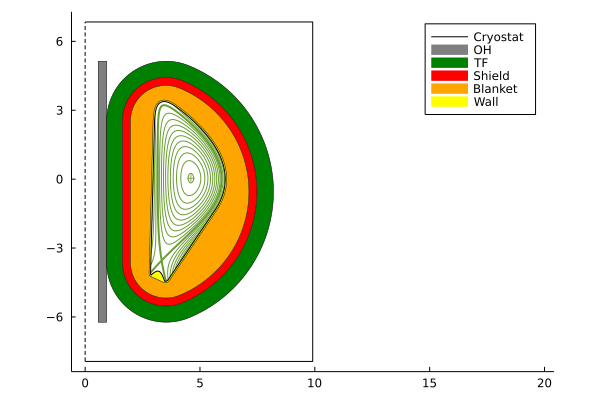

In [73]:
plot(dd.equilibrium)
display(plot!(dd.build))

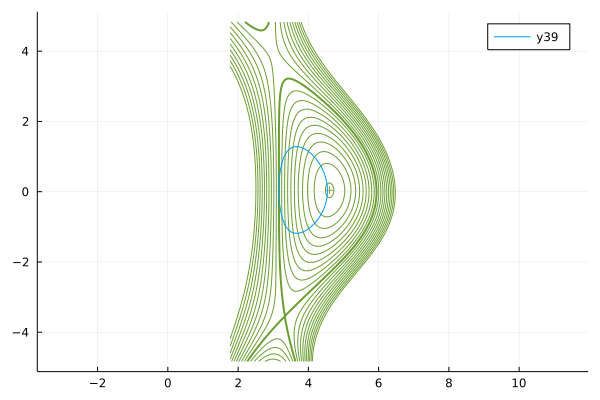

In [74]:
# field null surface
dd.equilibrium.time_slice[1]= FUSE.field_null_surface(dd.equilibrium.time_slice[])
dd.equilibrium.vacuum_toroidal_field.b0[1]=@ddtime(dd.equilibrium.vacuum_toroidal_field.b0)

plot(dd.equilibrium.time_slice[2])
plot!(dd.equilibrium.time_slice[1].boundary.outline.r,dd.equilibrium.time_slice[1].boundary.outline.z)

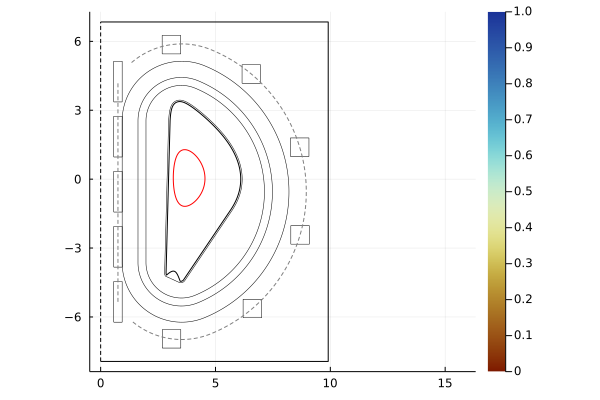

 * Status: success

 * Candidate solution
    Final objective value:     2.162684e-02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-04

 * Work counters
    Seconds run:   11  (vs limit 120)
    Iterations:    143
    f(x) calls:    266



contours not sorted in ascending order


In [75]:
# initialize pf actor
pfoptactor = PFcoilsOptActor(dd.equilibrium, dd.build, dd.pf_active, [5, 6]; coil_model=:simple)
display(plot(pfoptactor, rail=true))
FUSE.step(pfoptactor, λ_ψ=1E-2, λ_null=1E10, λ_currents=5E5, λ_strike=0.0, verbose=true, symmetric=false, maxiter=1000, optimization_scheme=:rail);
FUSE.finalize(pfoptactor);

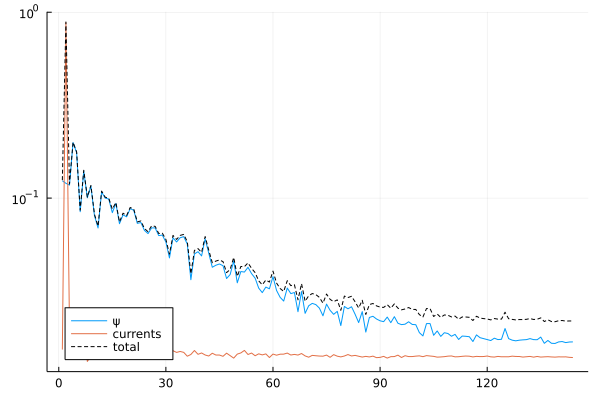

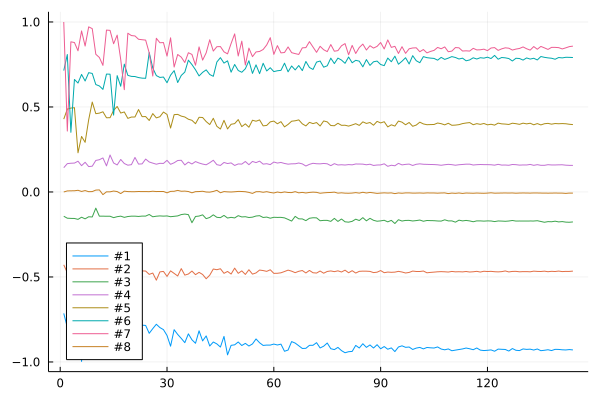

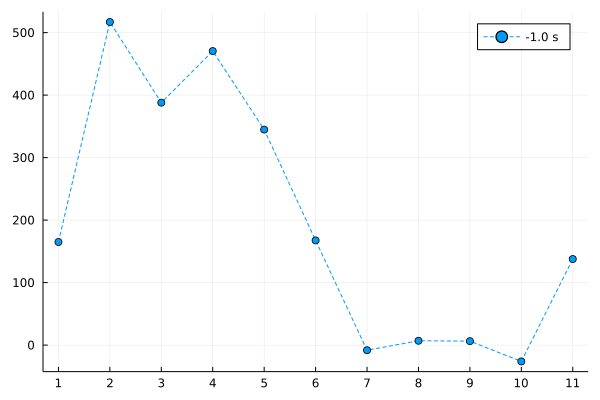

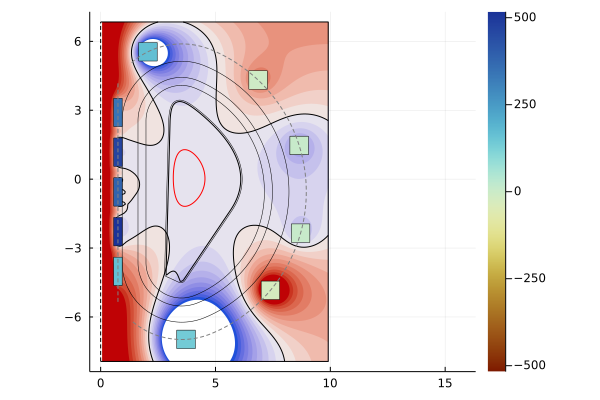

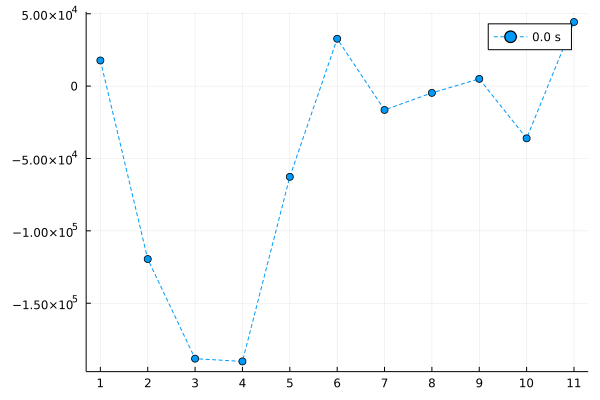

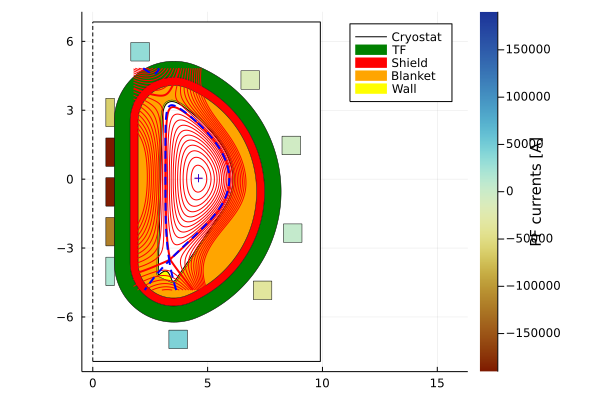

In [76]:
display(plot(pfoptactor.trace,:cost,start_at=1))
display(plot(pfoptactor.trace,:params,start_at=1))

display(plot(pfoptactor.pf_active,:currents, time_index=1))
display(plot(pfoptactor,equilibrium=true,rail=true,time_index=1))

display(plot(pfoptactor.pf_active,:currents, time_index=2))
display(plot(pfoptactor,equilibrium=true,time_index=2))

In [77]:
dd1=deepcopy(dd);
psi1 = pfoptactor.eq_out.time_slice[2].profiles_2d[1].psi;

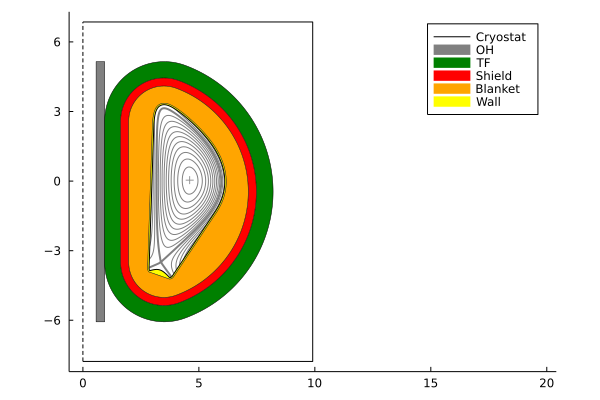

In [78]:
dd=deepcopy(dd1);
dd.equilibrium.time_slice[2].profiles_2d[1].psi = psi1

FUSE.build_cx(dd.build, dd.equilibrium.time_slice[], 2);
plot(dd.equilibrium,color=:gray)
display(plot!(dd.build))

In [79]:
# initialize pf actor
pfoptactor = PFcoilsOptActor(dd.equilibrium, dd.build, dd.pf_active, [5, 6]; coil_model=:simple)
pfoptactor.pf_active = deepcopy(dd1.pf_active)
FUSE.step(pfoptactor, λ_ψ=1E-2, λ_null=1E-2, λ_currents=5E5, λ_strike=1.0, verbose=true, symmetric=false, maxiter=10000, optimization_scheme=:static);
FUSE.finalize(pfoptactor);

 * Status: success

 * Candidate solution
    Final objective value:     3.070136e-02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-04

 * Work counters
    Seconds run:   0  (vs limit 120)
    Iterations:    3
    f(x) calls:    14



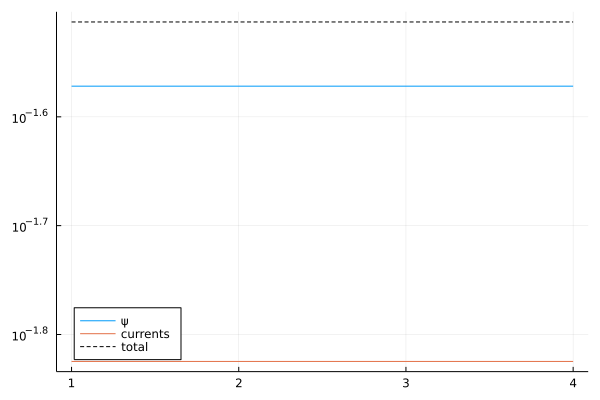

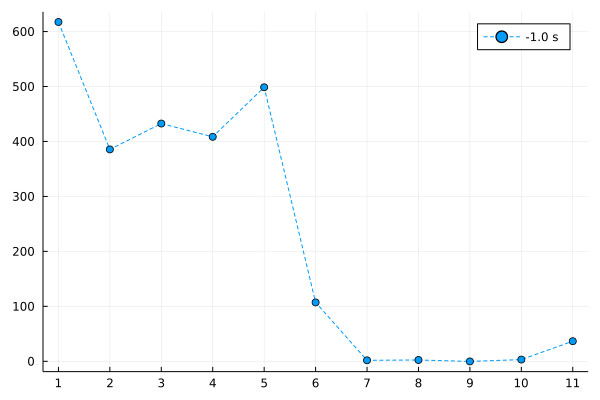

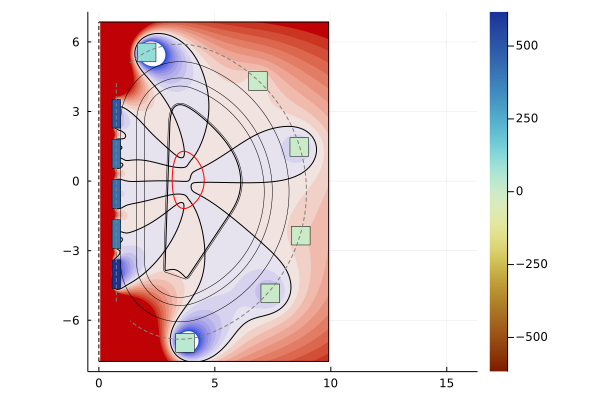

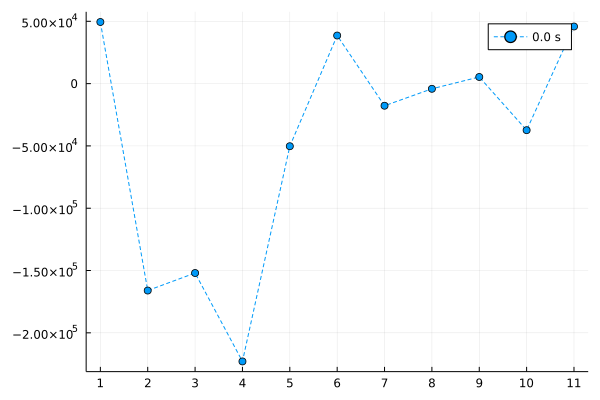

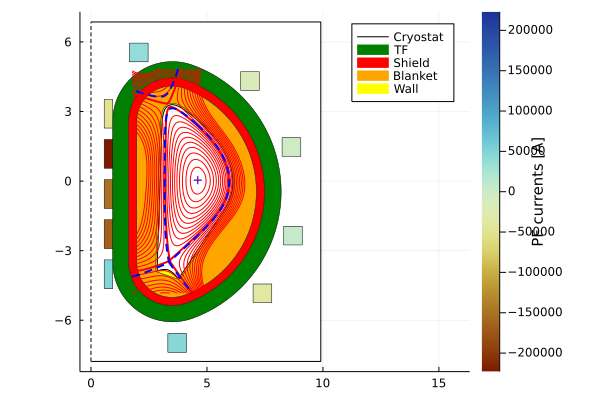

In [80]:
display(plot(pfoptactor.trace,:cost,start_at=1))

display(plot(pfoptactor.pf_active,:currents, time_index=1))
display(plot(pfoptactor,equilibrium=true,rail=true,time_index=1))

display(plot(pfoptactor.pf_active,:currents, time_index=2))
display(plot(pfoptactor,equilibrium=true,time_index=2))

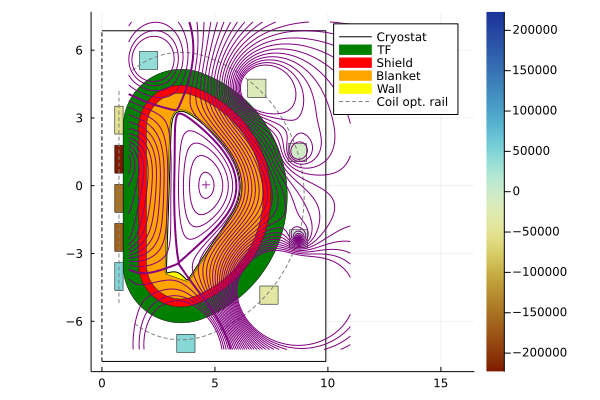

In [81]:
FUSE.finalize(pfoptactor, scale_eq_domain_size=1.5);
plot(pfoptactor,time_index=2,equilibrium=false,rail=true)
plot!(pfoptactor.eq_out.time_slice[2],color=:purple, psi_levels=5, psi_levels_out=21,xlim=[0,16])